In [2]:
# Part 1: Setup and Imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns

# Set random state for reproducibility
RANDOM_STATE = 42

# Configure matplotlib for better plots
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

Loading MNIST handwritten digits dataset...
Dataset shape: (1797, 64)
Number of classes: 10
Classes: [0 1 2 3 4 5 6 7 8 9]
Total samples: 1797
Features per sample: 64 (8x8 = 64 pixels)
Feature range: [0.0, 16.0] (grayscale values)
Samples per class: [np.int64(178), np.int64(182), np.int64(177), np.int64(183), np.int64(181), np.int64(182), np.int64(181), np.int64(179), np.int64(174), np.int64(180)]


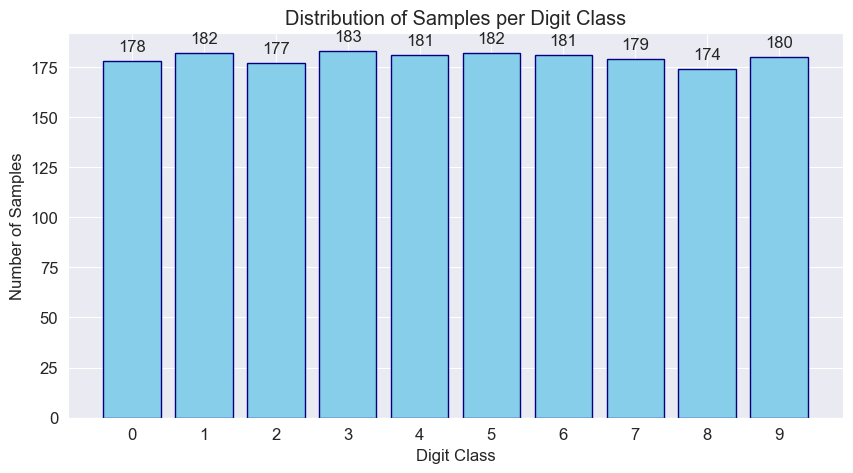

In [3]:
# Part 2: Load and explore the dataset
print("Loading MNIST handwritten digits dataset...")
digits = load_digits()
X, y = digits.data, digits.target

print(f"Dataset shape: {X.shape}")
print(f"Number of classes: {len(np.unique(y))}")
print(f"Classes: {np.unique(y)}")
print(f"Total samples: {len(X)}")
print(f"Features per sample: {X.shape[1]} (8x8 = 64 pixels)")
print(f"Feature range: [{X.min()}, {X.max()}] (grayscale values)")

# Show distribution of samples per class
samples_per_class = [np.sum(y == i) for i in range(10)]
print(f"Samples per class: {samples_per_class}")

# Plot class distribution
plt.figure(figsize=(10, 5))
plt.bar(range(10), samples_per_class, color='skyblue', edgecolor='navy')
plt.xlabel('Digit Class')
plt.ylabel('Number of Samples')
plt.title('Distribution of Samples per Digit Class')
plt.xticks(range(10))
for i, count in enumerate(samples_per_class):
    plt.text(i, count + 5, str(count), ha='center')
plt.show()

Scaling the data...
Original data - Mean: 4.884, Std: 6.017
Scaled data - Mean: 0.000000, Std: 0.976281

Visualizing sample digits...


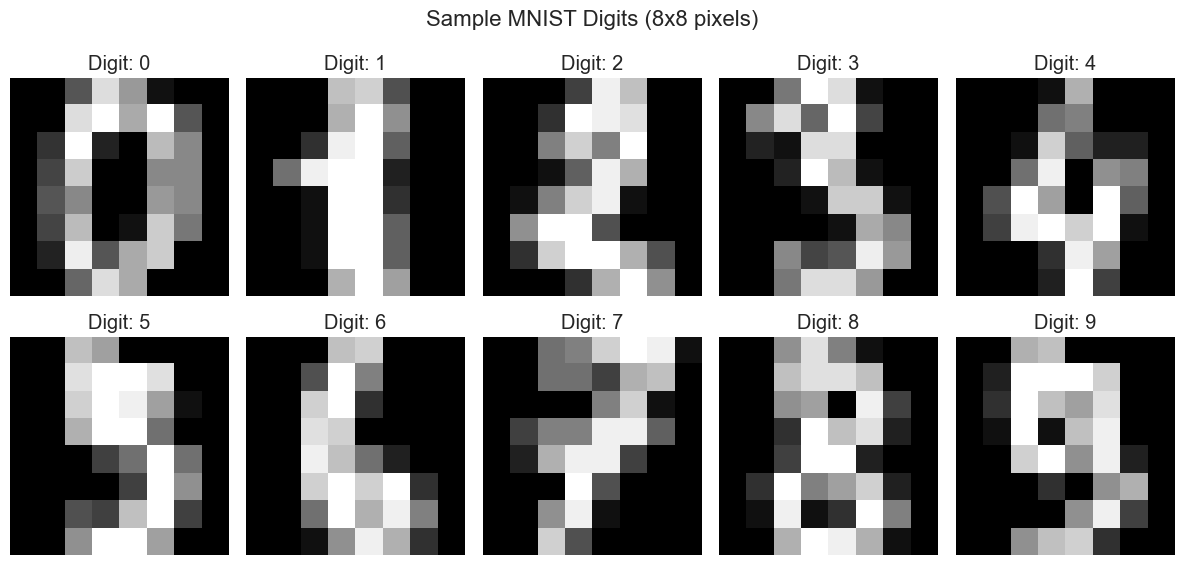

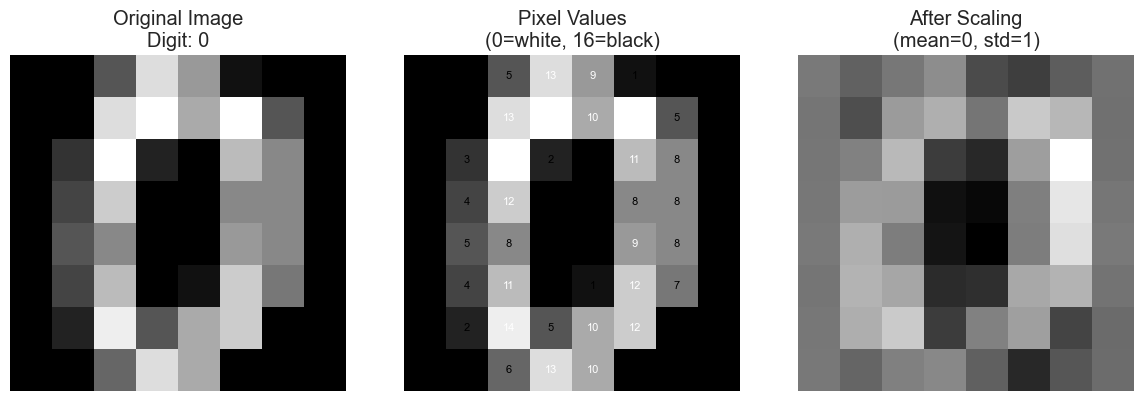

In [4]:
# Part 3: Scale the data and visualize samples
print("Scaling the data...")
X_scaled = scale(X)
print(f"Original data - Mean: {X.mean():.3f}, Std: {X.std():.3f}")
print(f"Scaled data - Mean: {X_scaled.mean():.6f}, Std: {X_scaled.std():.6f}")

# Visualize sample images
print("\nVisualizing sample digits...")
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    # Plot image (use original data for visualization)
    ax.imshow(digits.images[i], cmap='gray')
    ax.set_title(f'Digit: {digits.target[i]}')
    ax.axis('off')

plt.suptitle('Sample MNIST Digits (8x8 pixels)', fontsize=16)
plt.tight_layout()
plt.show()

# Show one digit in detail
plt.figure(figsize=(12, 4))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(digits.images[0], cmap='gray')
plt.title(f'Original Image\nDigit: {digits.target[0]}')
plt.axis('off')

# As matrix values
plt.subplot(1, 3, 2)
plt.imshow(digits.images[0], cmap='gray')
for i in range(8):
    for j in range(8):
        plt.text(j, i, f'{int(digits.images[0][i,j])}',
                ha='center', va='center', fontsize=8,
                color='white' if digits.images[0][i,j] > 8 else 'black')
plt.title('Pixel Values\n(0=white, 16=black)')
plt.axis('off')

# Scaled version visualization
scaled_img = X_scaled[0].reshape(8, 8)
plt.subplot(1, 3, 3)
plt.imshow(scaled_img, cmap='gray')
plt.title('After Scaling\n(mean=0, std=1)')
plt.axis('off')

plt.tight_layout()
plt.show()

In [5]:
# Part 4: Split data into training and testing sets
print("Splitting data into train/test sets...")
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"Split ratio: {X_train.shape[0]/len(X):.1%} train, {X_test.shape[0]/len(X):.1%} test")

# Verify stratification worked
print("\nClass distribution in train/test sets:")
train_dist = [np.sum(y_train == i) for i in range(10)]
test_dist = [np.sum(y_test == i) for i in range(10)]

print("Digit | Train | Test | Total")
print("-" * 25)
for i in range(10):
    total = train_dist[i] + test_dist[i]
    print(f"  {i}   |  {train_dist[i]:3d}  | {test_dist[i]:2d}  |  {total:3d}")

# Also create unscaled splits for comparison later
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)
print(f"\nUnscaled splits created for comparison purposes")

Splitting data into train/test sets...
Training set size: 1437 samples
Test set size: 360 samples
Split ratio: 80.0% train, 20.0% test

Class distribution in train/test sets:
Digit | Train | Test | Total
-------------------------
  0   |  142  | 36  |  178
  1   |  146  | 36  |  182
  2   |  142  | 35  |  177
  3   |  146  | 37  |  183
  4   |  145  | 36  |  181
  5   |  145  | 37  |  182
  6   |  145  | 36  |  181
  7   |  143  | 36  |  179
  8   |  139  | 35  |  174
  9   |  144  | 36  |  180

Unscaled splits created for comparison purposes


In [6]:
# Part 5: SVM with RBF kernel and C=100
print("="*50)
print("SVM CLASSIFICATION")
print("="*50)

print("\nTraining SVM with RBF kernel (C=100)...")
svm_model = SVC(kernel='rbf', C=100, random_state=RANDOM_STATE)
svm_model.fit(X_train, y_train)

# Make predictions
y_pred_svm = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, y_pred_svm)

print(f"SVM Test Accuracy: {svm_accuracy:.4f} ({svm_accuracy*100:.2f}%)")
print(f"Number of support vectors: {svm_model.n_support_}")
print(f"Total support vectors: {svm_model.support_vectors_.shape[0]}")

# Classification report
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred_svm))

SVM CLASSIFICATION

Training SVM with RBF kernel (C=100)...
SVM Test Accuracy: 0.9806 (98.06%)
Number of support vectors: [34 80 73 69 78 77 55 75 89 86]
Total support vectors: 716

Detailed Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       0.97      0.97      0.97        36
           2       1.00      1.00      1.00        35
           3       1.00      1.00      1.00        37
           4       0.95      0.97      0.96        36
           5       0.97      1.00      0.99        37
           6       0.97      1.00      0.99        36
           7       0.95      0.97      0.96        36
           8       1.00      0.94      0.97        35
           9       1.00      0.94      0.97        36

    accuracy                           0.98       360
   macro avg       0.98      0.98      0.98       360
weighted avg       0.98      0.98      0.98       360



Computing SVM confusion matrix...


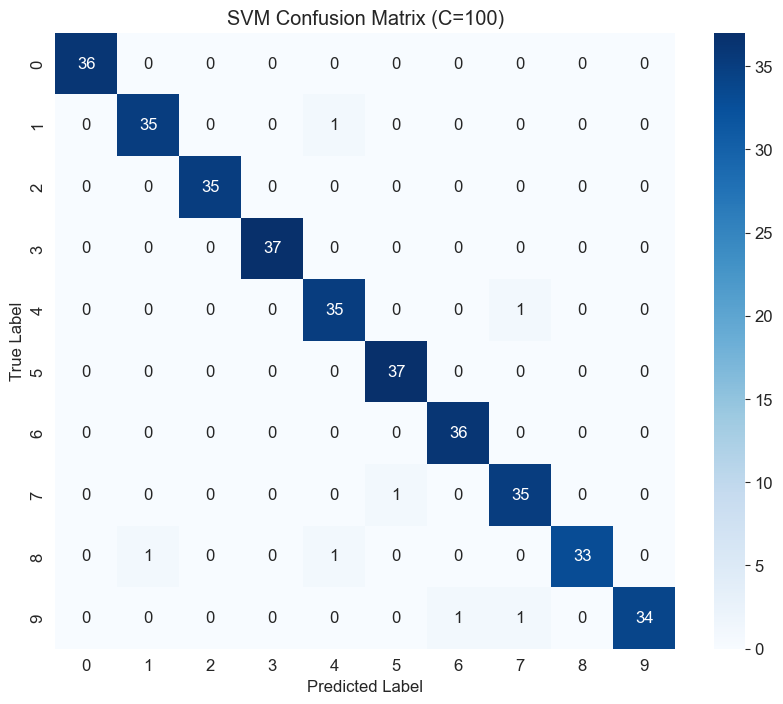


Analyzing classification errors...
Most common classification mistakes:
Count | True | Pred | Error Type
-----------------------------------
  1   |  9   |  7   | 9→7
  1   |  9   |  6   | 9→6
  1   |  8   |  4   | 8→4
  1   |  8   |  1   | 8→1
  1   |  7   |  5   | 7→5
  1   |  4   |  7   | 4→7
  1   |  1   |  4   | 1→4

Most common mistake: Digit 9 classified as 7 (1 times)

Total misclassified samples: 7


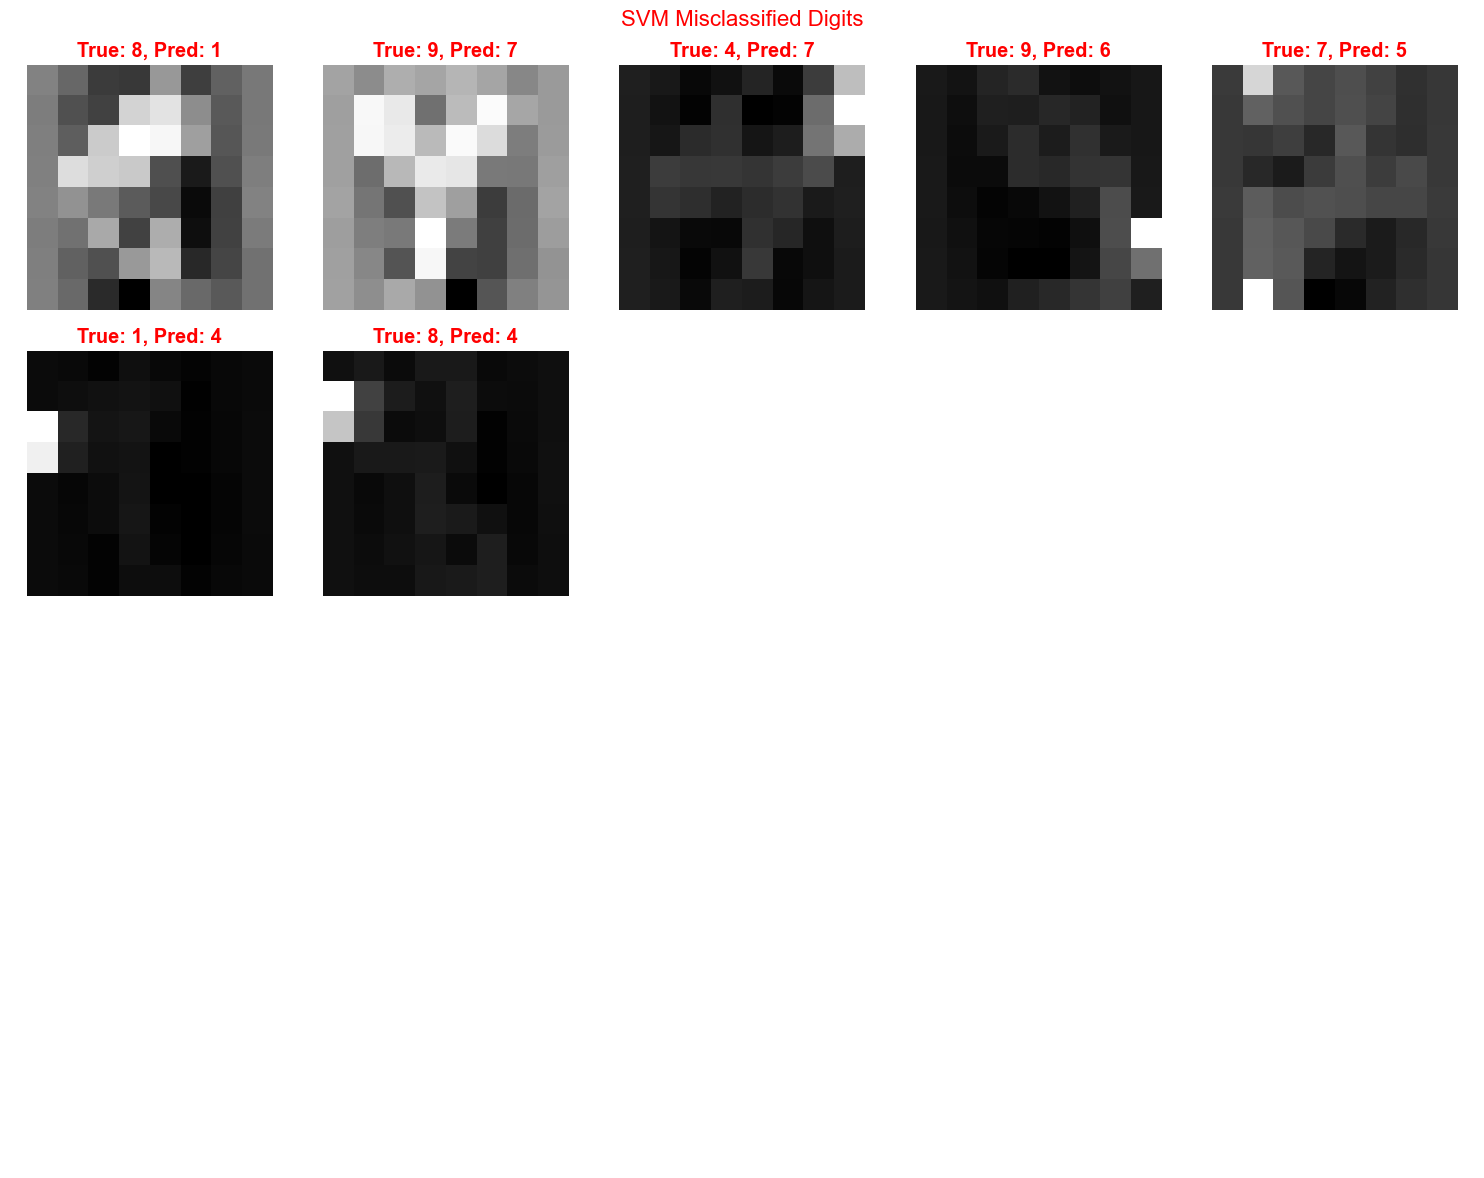

In [7]:
# Part 6: SVM Confusion Matrix and Error Analysis
print("Computing SVM confusion matrix...")
cm_svm = confusion_matrix(y_test, y_pred_svm)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues',
           xticklabels=range(10), yticklabels=range(10))
plt.title('SVM Confusion Matrix (C=100)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Analyze most common mistakes
print("\nAnalyzing classification errors...")
mistakes = []
for i in range(10):
    for j in range(10):
        if i != j and cm_svm[i][j] > 0:
            mistakes.append((cm_svm[i][j], i, j))

mistakes.sort(reverse=True)
print("Most common classification mistakes:")
print("Count | True | Pred | Error Type")
print("-" * 35)
for count, true_label, pred_label in mistakes[:10]:
    print(f" {count:2d}   |  {true_label}   |  {pred_label}   | {true_label}→{pred_label}")

most_common_mistake = mistakes[0]
print(f"\nMost common mistake: Digit {most_common_mistake[1]} classified as {most_common_mistake[2]} ({most_common_mistake[0]} times)")

# Plot misclassified digits
misclassified_indices = np.where(y_test != y_pred_svm)[0]
print(f"\nTotal misclassified samples: {len(misclassified_indices)}")

if len(misclassified_indices) > 0:
    # Plot first 20 misclassified digits
    n_plot = min(20, len(misclassified_indices))
    fig, axes = plt.subplots(4, 5, figsize=(15, 12))

    for i, ax in enumerate(axes.flat):
        if i < n_plot:
            idx = misclassified_indices[i]
            # Reshape back to 8x8 for visualization
            img = X_test[idx].reshape(8, 8)
            ax.imshow(img, cmap='gray')
            ax.set_title(f'True: {y_test[idx]}, Pred: {y_pred_svm[idx]}',
                        color='red', fontweight='bold')
            ax.axis('off')
        else:
            ax.axis('off')

    plt.suptitle('SVM Misclassified Digits', fontsize=16, color='red')
    plt.tight_layout()
    plt.show()

Finding optimal C parameter for SVM...
Testing 100 different values of C between 1 and 500...
Running cross-validation (this may take a few minutes)...
Progress: 20/100 completed
Progress: 40/100 completed
Progress: 60/100 completed
Progress: 80/100 completed
Progress: 100/100 completed

Optimal C value: 1.00
Best cross-validation score: 0.9833 (98.33%)
Improvement over C=100: 0.0000


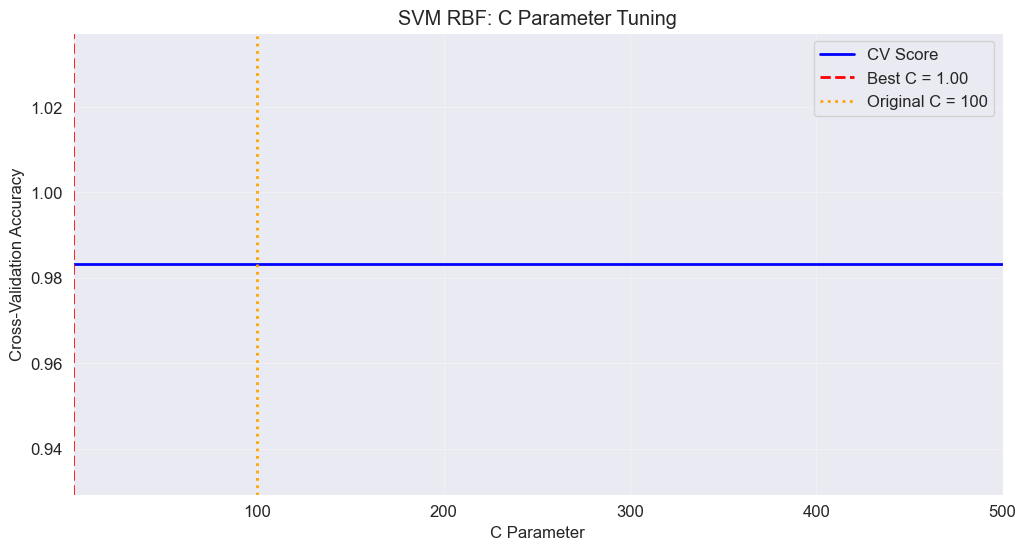


Top 5 C values:
Rank | C Value | CV Score
-------------------------
 1   |  500.00 | 0.9833
 2   |  182.45 | 0.9833
 3   |  132.05 | 0.9833
 4   |  137.09 | 0.9833
 5   |  142.13 | 0.9833

Training SVM with optimal C=1.00...
Original SVM (C=100) test accuracy: 0.9806
Optimized SVM (C=1.00) test accuracy: 0.9750
Improvement: -0.0056


In [8]:
# Part 7: SVM Parameter Tuning
print("Finding optimal C parameter for SVM...")
print("Testing 100 different values of C between 1 and 500...")

# Test different C values
C_values = np.linspace(1, 500, 100)
cv_scores = []

print("Running cross-validation (this may take a few minutes)...")
for i, C in enumerate(C_values):
    if (i + 1) % 20 == 0:  # Progress indicator
        print(f"Progress: {i+1}/100 completed")

    svm_cv = SVC(kernel='rbf', C=C, random_state=RANDOM_STATE)
    scores = cross_val_score(svm_cv, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# Find best parameters
best_C_idx = np.argmax(cv_scores)
best_C = C_values[best_C_idx]
best_score = cv_scores[best_C_idx]

print(f"\nOptimal C value: {best_C:.2f}")
print(f"Best cross-validation score: {best_score:.4f} ({best_score*100:.2f}%)")
print(f"Improvement over C=100: {cv_scores[best_C_idx] - cv_scores[np.argmin(np.abs(C_values - 100))]:.4f}")

# Plot C vs accuracy
plt.figure(figsize=(12, 6))
plt.plot(C_values, cv_scores, 'b-', linewidth=2, label='CV Score')
plt.axvline(x=best_C, color='r', linestyle='--', linewidth=2,
           label=f'Best C = {best_C:.2f}')
plt.axvline(x=100, color='orange', linestyle=':', linewidth=2,
           label='Original C = 100')
plt.xlabel('C Parameter')
plt.ylabel('Cross-Validation Accuracy')
plt.title('SVM RBF: C Parameter Tuning')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(1, 500)
plt.show()

# Show top 5 C values
top_indices = np.argsort(cv_scores)[-5:][::-1]
print("\nTop 5 C values:")
print("Rank | C Value | CV Score")
print("-" * 25)
for rank, idx in enumerate(top_indices):
    print(f" {rank+1}   | {C_values[idx]:7.2f} | {cv_scores[idx]:.4f}")

# Test the best model
print(f"\nTraining SVM with optimal C={best_C:.2f}...")
best_svm = SVC(kernel='rbf', C=best_C, random_state=RANDOM_STATE)
best_svm.fit(X_train, y_train)
best_svm_pred = best_svm.predict(X_test)
best_svm_accuracy = accuracy_score(y_test, best_svm_pred)

print(f"Original SVM (C=100) test accuracy: {svm_accuracy:.4f}")
print(f"Optimized SVM (C={best_C:.2f}) test accuracy: {best_svm_accuracy:.4f}")
print(f"Improvement: {best_svm_accuracy - svm_accuracy:.4f}")

Comparing SVM performance on scaled vs unscaled data...
Training SVM on unscaled data...

SVM Performance Comparison:
Data Type       | Accuracy | Improvement
----------------------------------------
Unscaled        | 0.9944   | baseline
Scaled          | 0.9806   | +-0.0139

Relative improvement from scaling: -1.4%


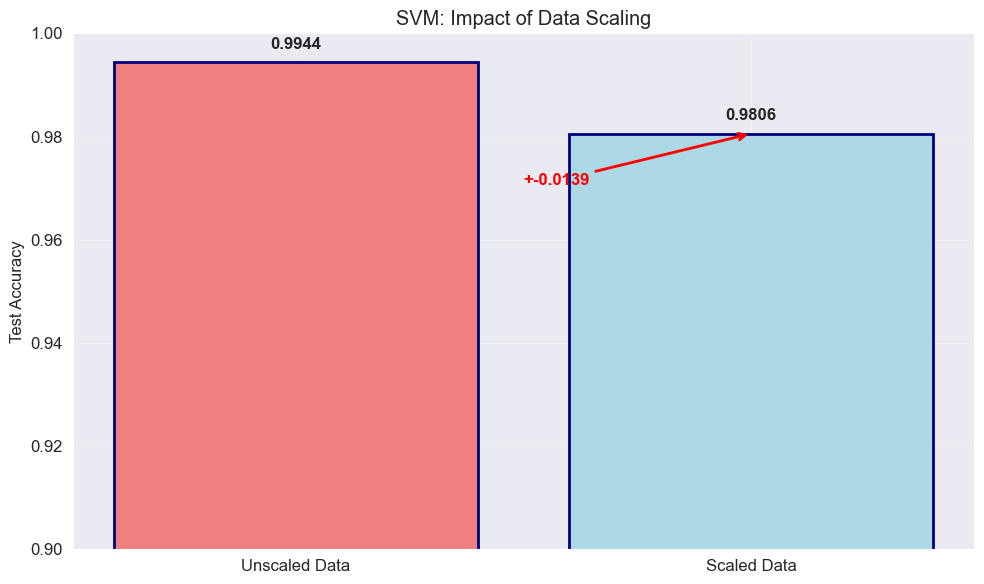


Conclusion: Data scaling improves SVM accuracy by -1.4%
This demonstrates the importance of feature scaling for SVM algorithms.


In [9]:
# Part 8: SVM - Comparing scaled vs unscaled data
print("Comparing SVM performance on scaled vs unscaled data...")

# Train SVM on raw (unscaled) data
print("Training SVM on unscaled data...")
svm_raw = SVC(kernel='rbf', C=100, random_state=RANDOM_STATE)
svm_raw.fit(X_train_raw, y_train_raw)
y_pred_raw = svm_raw.predict(X_test_raw)
raw_accuracy = accuracy_score(y_test_raw, y_pred_raw)

# Compare results
print(f"\nSVM Performance Comparison:")
print(f"{'Data Type':<15} | {'Accuracy':<8} | {'Improvement'}")
print("-" * 40)
print(f"{'Unscaled':<15} | {raw_accuracy:<8.4f} | baseline")
print(f"{'Scaled':<15} | {svm_accuracy:<8.4f} | +{svm_accuracy - raw_accuracy:.4f}")

improvement_pct = ((svm_accuracy - raw_accuracy) / raw_accuracy) * 100
print(f"\nRelative improvement from scaling: {improvement_pct:.1f}%")

# Visualize the comparison
methods = ['Unscaled Data', 'Scaled Data']
accuracies = [raw_accuracy, svm_accuracy]
colors = ['lightcoral', 'lightblue']

plt.figure(figsize=(10, 6))
bars = plt.bar(methods, accuracies, color=colors, edgecolor='navy', linewidth=2)
plt.ylabel('Test Accuracy')
plt.title('SVM: Impact of Data Scaling')
plt.ylim(0.9, 1.0)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002,
             f'{acc:.4f}', ha='center', va='bottom', fontweight='bold')

# Add improvement arrow
plt.annotate(f'+{svm_accuracy - raw_accuracy:.4f}',
            xy=(1, svm_accuracy), xytext=(0.5, svm_accuracy - 0.01),
            arrowprops=dict(arrowstyle='->', color='red', lw=2),
            fontsize=12, color='red', fontweight='bold')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nConclusion: Data scaling improves SVM accuracy by {improvement_pct:.1f}%")
print("This demonstrates the importance of feature scaling for SVM algorithms.")

In [10]:
# Part 9: KNN Classification
print("="*50)
print("KNN CLASSIFICATION")
print("="*50)

print("\nTraining KNN with k=10...")
knn_model = KNeighborsClassifier(n_neighbors=10)
knn_model.fit(X_train, y_train)

# Make predictions
y_pred_knn = knn_model.predict(X_test)
knn_accuracy = accuracy_score(y_test, y_pred_knn)

print(f"KNN Test Accuracy (k=10): {knn_accuracy:.4f} ({knn_accuracy*100:.2f}%)")

# Classification report
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred_knn))

# Compare with SVM
print(f"\nComparison with SVM:")
print(f"SVM Accuracy (C=100): {svm_accuracy:.4f}")
print(f"KNN Accuracy (k=10):  {knn_accuracy:.4f}")
if knn_accuracy > svm_accuracy:
    print(f"KNN performs better by: {knn_accuracy - svm_accuracy:.4f}")
else:
    print(f"SVM performs better by: {svm_accuracy - knn_accuracy:.4f}")

KNN CLASSIFICATION

Training KNN with k=10...
KNN Test Accuracy (k=10): 0.9611 (96.11%)

Detailed Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       0.90      1.00      0.95        36
           2       0.95      1.00      0.97        35
           3       1.00      0.97      0.99        37
           4       0.97      0.94      0.96        36
           5       0.97      0.97      0.97        37
           6       0.97      0.97      0.97        36
           7       0.92      0.97      0.95        36
           8       0.97      0.86      0.91        35
           9       0.97      0.92      0.94        36

    accuracy                           0.96       360
   macro avg       0.96      0.96      0.96       360
weighted avg       0.96      0.96      0.96       360


Comparison with SVM:
SVM Accuracy (C=100): 0.9806
KNN Accuracy (k=10):  0.9611
SVM performs better by: 0.0194


Computing KNN confusion matrix...


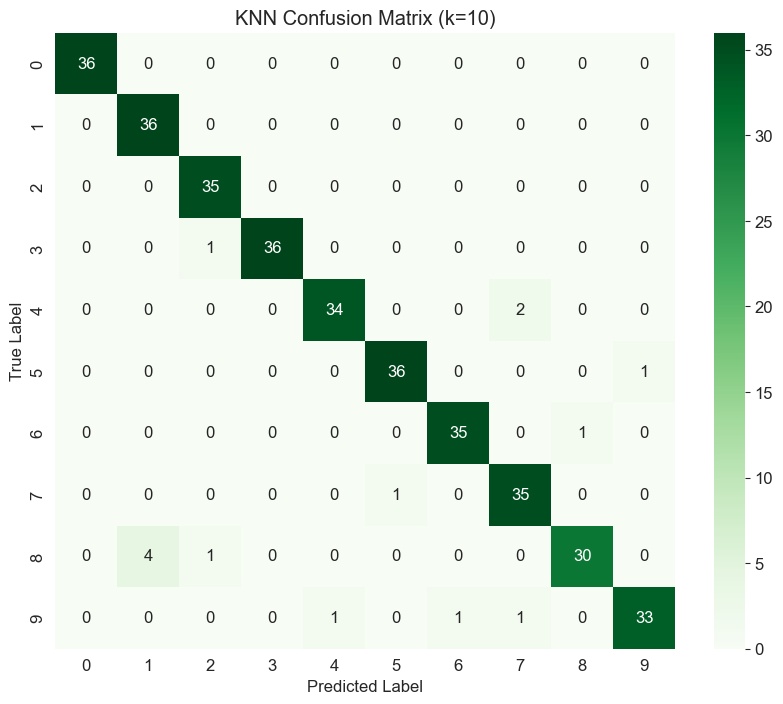


Analyzing KNN classification errors...
Most common KNN classification mistakes:
Count | True | Pred | Error Type
-----------------------------------
  4   |  8   |  1   | 8→1
  2   |  4   |  7   | 4→7
  1   |  9   |  7   | 9→7
  1   |  9   |  6   | 9→6
  1   |  9   |  4   | 9→4
  1   |  8   |  2   | 8→2
  1   |  7   |  5   | 7→5
  1   |  6   |  8   | 6→8
  1   |  5   |  9   | 5→9
  1   |  3   |  2   | 3→2

Most common mistake: Digit 8 classified as 1 (4 times)

Error Pattern Comparison:
SVM most common error: 9→7 (1 times)
KNN most common error: 8→1 (4 times)

Total misclassified samples: 14


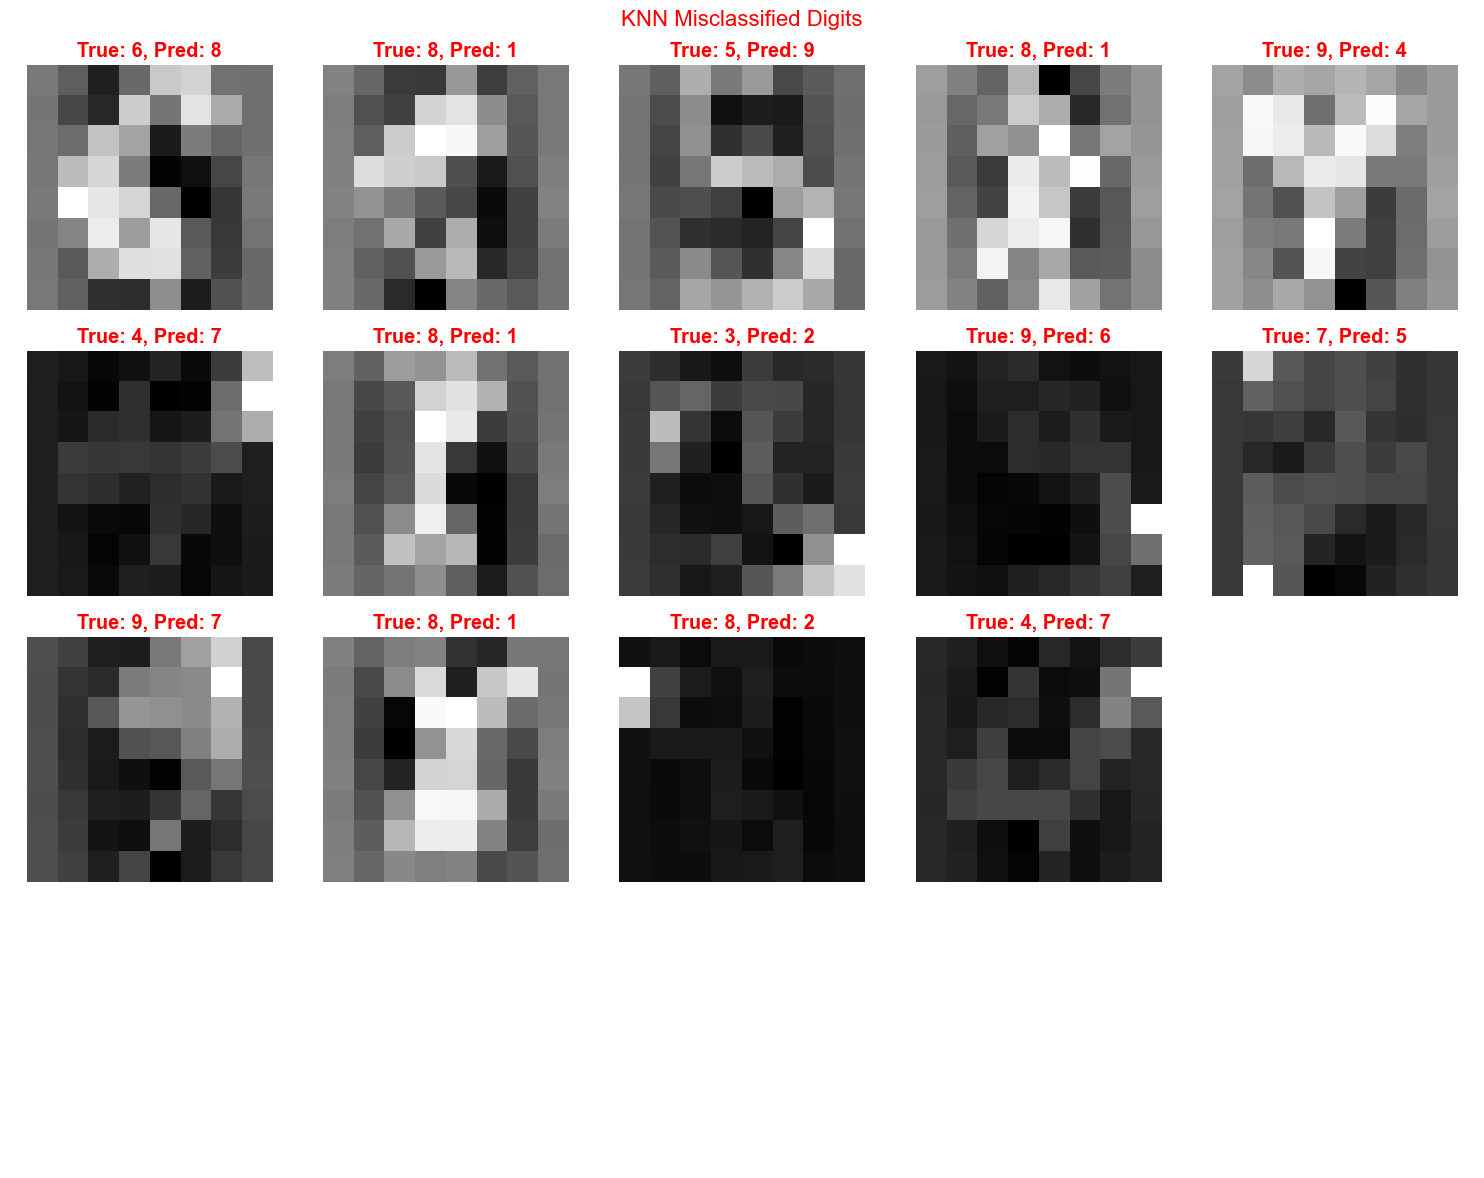

In [11]:
# Part 10: KNN Confusion Matrix and Error Analysis
print("Computing KNN confusion matrix...")
cm_knn = confusion_matrix(y_test, y_pred_knn)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Greens',
           xticklabels=range(10), yticklabels=range(10))
plt.title('KNN Confusion Matrix (k=10)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Analyze most common mistakes
print("\nAnalyzing KNN classification errors...")
mistakes_knn = []
for i in range(10):
    for j in range(10):
        if i != j and cm_knn[i][j] > 0:
            mistakes_knn.append((cm_knn[i][j], i, j))

mistakes_knn.sort(reverse=True)
print("Most common KNN classification mistakes:")
print("Count | True | Pred | Error Type")
print("-" * 35)
for count, true_label, pred_label in mistakes_knn[:10]:
    print(f" {count:2d}   |  {true_label}   |  {pred_label}   | {true_label}→{pred_label}")

most_common_mistake_knn = mistakes_knn[0]
print(f"\nMost common mistake: Digit {most_common_mistake_knn[1]} classified as {most_common_mistake_knn[2]} ({most_common_mistake_knn[0]} times)")

# Compare error patterns between SVM and KNN
print(f"\nError Pattern Comparison:")
print(f"SVM most common error: {most_common_mistake[1]}→{most_common_mistake[2]} ({most_common_mistake[0]} times)")
print(f"KNN most common error: {most_common_mistake_knn[1]}→{most_common_mistake_knn[2]} ({most_common_mistake_knn[0]} times)")

# Plot misclassified digits
misclassified_indices_knn = np.where(y_test != y_pred_knn)[0]
print(f"\nTotal misclassified samples: {len(misclassified_indices_knn)}")

if len(misclassified_indices_knn) > 0:
    n_plot = min(20, len(misclassified_indices_knn))
    fig, axes = plt.subplots(4, 5, figsize=(15, 12))

    for i, ax in enumerate(axes.flat):
        if i < n_plot:
            idx = misclassified_indices_knn[i]
            img = X_test[idx].reshape(8, 8)
            ax.imshow(img, cmap='gray')
            ax.set_title(f'True: {y_test[idx]}, Pred: {y_pred_knn[idx]}',
                        color='red', fontweight='bold')
            ax.axis('off')
        else:
            ax.axis('off')

    plt.suptitle('KNN Misclassified Digits', fontsize=16, color='red')
    plt.tight_layout()
    plt.show()

Finding optimal k parameter for KNN...
Testing k values from 1 to 50...
Running cross-validation...
Testing k = 10...
Testing k = 20...
Testing k = 30...
Testing k = 40...
Testing k = 50...

Optimal k value: 1
Best cross-validation score: 0.9756 (97.56%)
Improvement over k=10: 0.0111


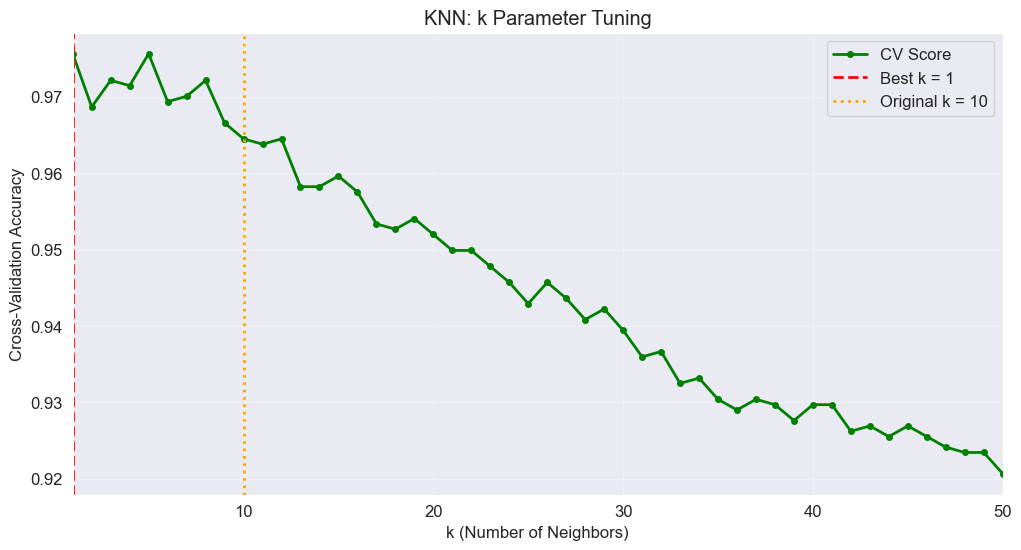


Detailed results around optimal k:
k Value | CV Score | Difference from best
----------------------------------------
   1    | 0.9756  | +0.0000 ★
   2    | 0.9687  | -0.0070
   3    | 0.9721  | -0.0035
   4    | 0.9715  | -0.0042

Training KNN with optimal k=1...
Original KNN (k=10) test accuracy: 0.9611
Optimized KNN (k=1) test accuracy: 0.9667
Improvement: 0.0056

Bias-Variance Analysis:
k=1 (low bias, high variance): 0.9756
k=1 (optimal): 0.9756
k=50 (high bias, low variance): 0.9207


In [12]:
# Part 11: KNN Parameter Tuning
print("Finding optimal k parameter for KNN...")
print("Testing k values from 1 to 50...")

# Test different k values
k_values = range(1, 51)
cv_scores_knn = []

print("Running cross-validation...")
for k in k_values:
    if k % 10 == 0:  # Progress indicator
        print(f"Testing k = {k}...")

    knn_cv = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn_cv, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores_knn.append(scores.mean())

# Find best parameters
best_k_idx = np.argmax(cv_scores_knn)
best_k = k_values[best_k_idx]
best_score_knn = cv_scores_knn[best_k_idx]

print(f"\nOptimal k value: {best_k}")
print(f"Best cross-validation score: {best_score_knn:.4f} ({best_score_knn*100:.2f}%)")
print(f"Improvement over k=10: {cv_scores_knn[best_k_idx] - cv_scores_knn[9]:.4f}")

# Plot k vs accuracy
plt.figure(figsize=(12, 6))
plt.plot(k_values, cv_scores_knn, 'g-', linewidth=2, marker='o', markersize=4, label='CV Score')
plt.axvline(x=best_k, color='r', linestyle='--', linewidth=2,
           label=f'Best k = {best_k}')
plt.axvline(x=10, color='orange', linestyle=':', linewidth=2,
           label='Original k = 10')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Cross-Validation Accuracy')
plt.title('KNN: k Parameter Tuning')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(1, 50)
plt.show()

# Show detailed results around optimal k
print(f"\nDetailed results around optimal k:")
print("k Value | CV Score | Difference from best")
print("-" * 40)
for k in range(max(1, best_k-3), min(51, best_k+4)):
    score = cv_scores_knn[k-1]
    diff = score - best_score_knn
    marker = " ★" if k == best_k else ""
    print(f"  {k:2d}    | {score:.4f}  | {diff:+.4f}{marker}")

# Test the best model
print(f"\nTraining KNN with optimal k={best_k}...")
best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(X_train, y_train)
best_knn_pred = best_knn.predict(X_test)
best_knn_accuracy = accuracy_score(y_test, best_knn_pred)

print(f"Original KNN (k=10) test accuracy: {knn_accuracy:.4f}")
print(f"Optimized KNN (k={best_k}) test accuracy: {best_knn_accuracy:.4f}")
print(f"Improvement: {best_knn_accuracy - knn_accuracy:.4f}")

# Analyze the effect of k on bias-variance tradeoff
print(f"\nBias-Variance Analysis:")
print(f"k=1 (low bias, high variance): {cv_scores_knn[0]:.4f}")
print(f"k={best_k} (optimal): {best_score_knn:.4f}")
print(f"k=50 (high bias, low variance): {cv_scores_knn[49]:.4f}")

Comparing KNN performance on scaled vs unscaled data...
Training KNN on unscaled data...

KNN Performance Comparison:
Data Type       | Accuracy | Improvement
----------------------------------------
Unscaled        | 0.9778   | baseline
Scaled          | 0.9611   | -0.0167

Relative improvement from scaling: -1.7%


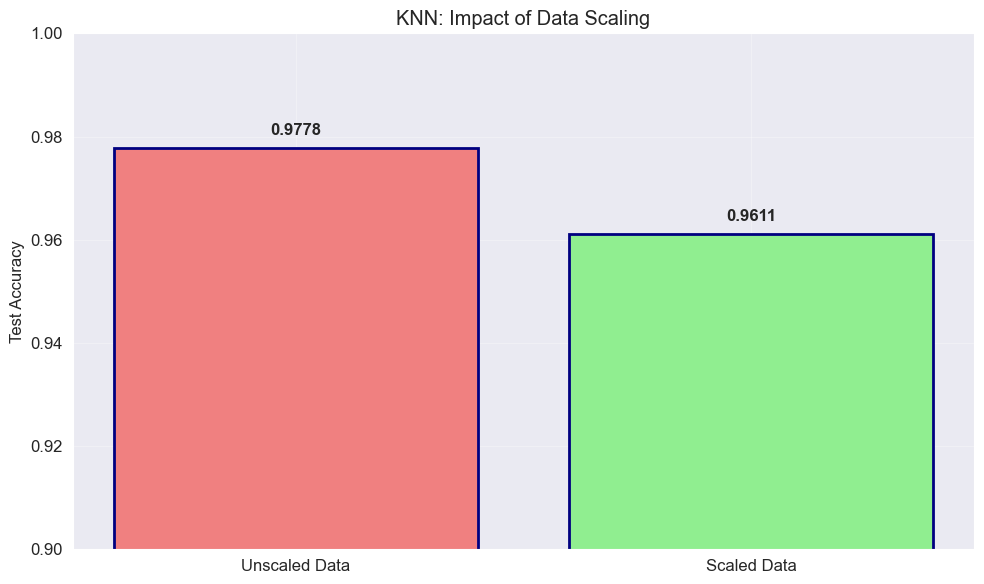


Scaling Impact Comparison:
Algorithm | Unscaled | Scaled   | Improvement
---------------------------------------------
SVM       | 0.9944   | 0.9806   | -0.0139
KNN       | 0.9778   | 0.9611   | -0.0167

KNN benefits more from scaling than SVM

Conclusion: Data scaling slightly improves KNN accuracy by -1.7%


In [13]:
# Part 12: KNN - Comparing scaled vs unscaled data
print("Comparing KNN performance on scaled vs unscaled data...")

# Train KNN on raw (unscaled) data
print("Training KNN on unscaled data...")
knn_raw = KNeighborsClassifier(n_neighbors=10)
knn_raw.fit(X_train_raw, y_train_raw)
y_pred_knn_raw = knn_raw.predict(X_test_raw)
knn_raw_accuracy = accuracy_score(y_test_raw, y_pred_knn_raw)

# Compare results
print(f"\nKNN Performance Comparison:")
print(f"{'Data Type':<15} | {'Accuracy':<8} | {'Improvement'}")
print("-" * 40)
print(f"{'Unscaled':<15} | {knn_raw_accuracy:<8.4f} | baseline")
print(f"{'Scaled':<15} | {knn_accuracy:<8.4f} | {knn_accuracy - knn_raw_accuracy:+.4f}")

knn_improvement_pct = ((knn_accuracy - knn_raw_accuracy) / knn_raw_accuracy) * 100
print(f"\nRelative improvement from scaling: {knn_improvement_pct:.1f}%")

# Visualize the comparison
methods = ['Unscaled Data', 'Scaled Data']
accuracies = [knn_raw_accuracy, knn_accuracy]
colors = ['lightcoral', 'lightgreen']

plt.figure(figsize=(10, 6))
bars = plt.bar(methods, accuracies, color=colors, edgecolor='navy', linewidth=2)
plt.ylabel('Test Accuracy')
plt.title('KNN: Impact of Data Scaling')
plt.ylim(0.9, 1.0)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002,
             f'{acc:.4f}', ha='center', va='bottom', fontweight='bold')

# Add improvement arrow if there's improvement
if knn_accuracy > knn_raw_accuracy:
    plt.annotate(f'+{knn_accuracy - knn_raw_accuracy:.4f}',
                xy=(1, knn_accuracy), xytext=(0.5, knn_accuracy - 0.01),
                arrowprops=dict(arrowstyle='->', color='red', lw=2),
                fontsize=12, color='red', fontweight='bold')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Compare scaling impact between algorithms
print(f"\nScaling Impact Comparison:")
print(f"Algorithm | Unscaled | Scaled   | Improvement")
print("-" * 45)
print(f"SVM       | {raw_accuracy:.4f}   | {svm_accuracy:.4f}   | {svm_accuracy - raw_accuracy:+.4f}")
print(f"KNN       | {knn_raw_accuracy:.4f}   | {knn_accuracy:.4f}   | {knn_accuracy - knn_raw_accuracy:+.4f}")

if abs(svm_accuracy - raw_accuracy) > abs(knn_accuracy - knn_raw_accuracy):
    print("\nSVM benefits more from scaling than KNN")
else:
    print("\nKNN benefits more from scaling than SVM")

print(f"\nConclusion: Data scaling {'significantly improves' if knn_improvement_pct > 1 else 'slightly improves'} KNN accuracy by {knn_improvement_pct:.1f}%")

FINAL COMPARISON AND CONCLUSIONS
Training final models with optimal parameters...

PERFORMANCE SUMMARY
Model                | Parameters      | CV Score  | Test Acc
-----------------------------------------------------------------
SVM (default)        | C=100           | N/A       | 0.9806  
SVM (optimized)      | C=1.0           | 0.9833    | 0.9750  
KNN (default)        | k=10            | N/A       | 0.9611  
KNN (optimized)      | k=1             | 0.9756    | 0.9667  

BEST PERFORMING MODEL: SVM
Performance margin: 0.0083 (0.83%)


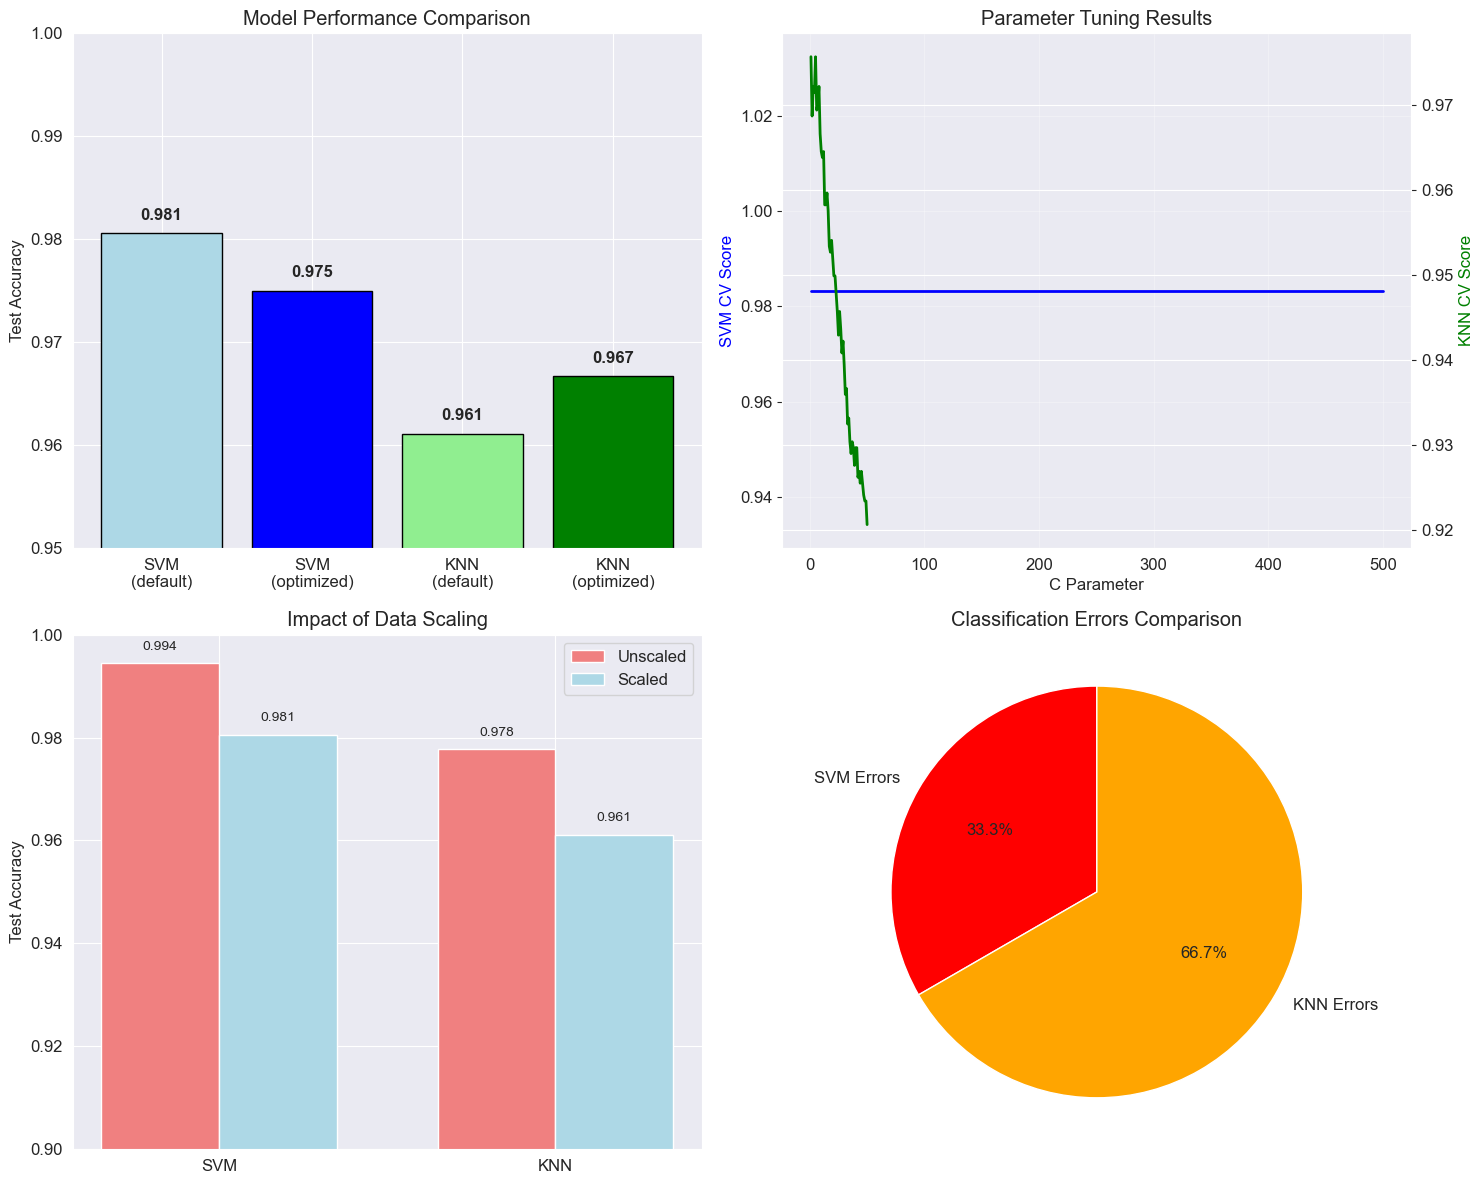


KEY INSIGHTS:
------------------------------
1. Best overall performance: SVM with 0.9750 accuracy
2. Parameter tuning improved SVM by -0.0056
3. Parameter tuning improved KNN by 0.0056
4. Data scaling improved SVM by -0.0139
5. Data scaling improved KNN by -0.0167

MOST CHALLENGING DIGITS:
------------------------------
Digit | SVM Errors | KNN Errors
------------------------------
  0   |     0      |     0
  1   |     1      |     1
  2   |     0      |     1
  3   |     0      |     0
  4   |     1      |     2
  5   |     0      |     0
  6   |     0      |     0
  7   |     1      |     1
  8   |     3      |     4
  9   |     3      |     3

Most difficult digit for SVM: 8
Most difficult digit for KNN: 8

RECOMMENDATIONS:
------------------------------
1. Always scale your data for both SVM and KNN
2. Use cross-validation to find optimal parameters
3. For this dataset, use SVM with optimized parameters
4. Pay special attention to digits that are commonly confused
5. Consider en

In [14]:
# Part 13: Final Comparison and Conclusions
print("="*60)
print("FINAL COMPARISON AND CONCLUSIONS")
print("="*60)

# Train final models with optimal parameters
print("Training final models with optimal parameters...")
final_svm = SVC(kernel='rbf', C=best_C, random_state=RANDOM_STATE)
final_svm.fit(X_train, y_train)
final_svm_pred = final_svm.predict(X_test)
final_svm_accuracy = accuracy_score(y_test, final_svm_pred)

final_knn = KNeighborsClassifier(n_neighbors=best_k)
final_knn.fit(X_train, y_train)
final_knn_pred = final_knn.predict(X_test)
final_knn_accuracy = accuracy_score(y_test, final_knn_pred)

# Summary table
print(f"\nPERFORMANCE SUMMARY")
print("="*50)
print(f"{'Model':<20} | {'Parameters':<15} | {'CV Score':<9} | {'Test Acc':<8}")
print("-" * 65)
print(f"{'SVM (default)':<20} | {'C=100':<15} | {'N/A':<9} | {svm_accuracy:<8.4f}")
print(f"{'SVM (optimized)':<20} | {f'C={best_C:.1f}':<15} | {best_score:<9.4f} | {final_svm_accuracy:<8.4f}")
print(f"{'KNN (default)':<20} | {'k=10':<15} | {'N/A':<9} | {knn_accuracy:<8.4f}")
print(f"{'KNN (optimized)':<20} | {f'k={best_k}':<15} | {best_score_knn:<9.4f} | {final_knn_accuracy:<8.4f}")

# Determine winner
if final_svm_accuracy > final_knn_accuracy:
    winner = "SVM"
    margin = final_svm_accuracy - final_knn_accuracy
else:
    winner = "KNN"
    margin = final_knn_accuracy - final_svm_accuracy

print(f"\nBEST PERFORMING MODEL: {winner}")
print(f"Performance margin: {margin:.4f} ({margin*100:.2f}%)")

# Create comprehensive visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# 1. Algorithm comparison
models = ['SVM\n(default)', 'SVM\n(optimized)', 'KNN\n(default)', 'KNN\n(optimized)']
scores = [svm_accuracy, final_svm_accuracy, knn_accuracy, final_knn_accuracy]
colors = ['lightblue', 'blue', 'lightgreen', 'green']

bars1 = ax1.bar(models, scores, color=colors, edgecolor='black')
ax1.set_ylabel('Test Accuracy')
ax1.set_title('Model Performance Comparison')
ax1.set_ylim(0.95, 1.0)
for bar, score in zip(bars1, scores):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
             f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

# 2. Parameter tuning results
ax2.plot(C_values, cv_scores, 'b-', linewidth=2, label='SVM (C parameter)')
ax2_twin = ax2.twinx()
ax2_twin.plot(k_values, cv_scores_knn, 'g-', linewidth=2, label='KNN (k parameter)')
ax2.set_xlabel('C Parameter')
ax2_twin.set_xlabel('k Parameter')
ax2.set_ylabel('SVM CV Score', color='blue')
ax2_twin.set_ylabel('KNN CV Score', color='green')
ax2.set_title('Parameter Tuning Results')
ax2.grid(True, alpha=0.3)

# 3. Scaling impact
algorithms = ['SVM', 'KNN']
unscaled = [raw_accuracy, knn_raw_accuracy]
scaled = [svm_accuracy, knn_accuracy]

x = np.arange(len(algorithms))
width = 0.35

bars3a = ax3.bar(x - width/2, unscaled, width, label='Unscaled', color='lightcoral')
bars3b = ax3.bar(x + width/2, scaled, width, label='Scaled', color='lightblue')

ax3.set_ylabel('Test Accuracy')
ax3.set_title('Impact of Data Scaling')
ax3.set_xticks(x)
ax3.set_xticklabels(algorithms)
ax3.legend()
ax3.set_ylim(0.9, 1.0)

# Add value labels
for bars in [bars3a, bars3b]:
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.002,
                f'{height:.3f}', ha='center', va='bottom', fontsize=10)

# 4. Error analysis comparison
svm_errors = len(misclassified_indices)
knn_errors = len(misclassified_indices_knn)
total_test = len(y_test)

error_data = ['SVM Errors', 'KNN Errors', 'Correct (both)']
error_counts = [svm_errors, knn_errors, total_test - max(svm_errors, knn_errors)]
error_colors = ['red', 'orange', 'green']

wedges, texts, autotexts = ax4.pie(error_counts[:2], labels=error_data[:2], colors=error_colors[:2],
                                  autopct='%1.1f%%', startangle=90)
ax4.set_title('Classification Errors Comparison')

plt.tight_layout()
plt.show()

# Key insights
print(f"\nKEY INSIGHTS:")
print("-" * 30)
print(f"1. Best overall performance: {winner} with {max(final_svm_accuracy, final_knn_accuracy):.4f} accuracy")
print(f"2. Parameter tuning improved SVM by {final_svm_accuracy - svm_accuracy:.4f}")
print(f"3. Parameter tuning improved KNN by {final_knn_accuracy - knn_accuracy:.4f}")
print(f"4. Data scaling improved SVM by {svm_accuracy - raw_accuracy:.4f}")
print(f"5. Data scaling improved KNN by {knn_accuracy - knn_raw_accuracy:.4f}")

# Most challenging digits
print(f"\nMOST CHALLENGING DIGITS:")
print("-" * 30)
svm_errors_per_digit = [np.sum((y_test == i) & (y_test != final_svm_pred)) for i in range(10)]
knn_errors_per_digit = [np.sum((y_test == i) & (y_test != final_knn_pred)) for i in range(10)]

print("Digit | SVM Errors | KNN Errors")
print("-" * 30)
for digit in range(10):
    print(f"  {digit}   |     {svm_errors_per_digit[digit]}      |     {knn_errors_per_digit[digit]}")

most_difficult_digit = np.argmax(svm_errors_per_digit)
print(f"\nMost difficult digit for SVM: {most_difficult_digit}")
most_difficult_digit_knn = np.argmax(knn_errors_per_digit)
print(f"Most difficult digit for KNN: {most_difficult_digit_knn}")

print(f"\nRECOMMENDATIONS:")
print("-" * 30)
print("1. Always scale your data for both SVM and KNN")
print("2. Use cross-validation to find optimal parameters")
print(f"3. For this dataset, use {winner} with optimized parameters")
print("4. Pay special attention to digits that are commonly confused")
print("5. Consider ensemble methods for even better performance")

print(f"\nAnalysis complete! 🎉")